# Assignment 6: Learning to Play Atari Breakout

## Overview
This notebook explores advanced reinforcement learning concepts through the Atari Breakout game, including value iteration, policy iteration, Monte Carlo control, and epsilon-greedy exploration.

## Theory

### Value Iteration
Value iteration computes the optimal value function by iteratively applying the Bellman optimality equation:

$$v_{k+1}(s) = \max_a \sum_{s',r} p(s',r|s,a)[r + \gamma v_k(s')]$$

Convergence: $\max_s |v_{k+1}(s) - v_k(s)| < \theta$

### Policy Iteration
Alternates between:
1. **Policy Evaluation**: Compute $v_\pi$
2. **Policy Improvement**: $\pi'(s) = \arg\max_a \sum_{s',r} p(s',r|s,a)[r + \gamma v_\pi(s')]$

### Epsilon-Greedy Exploration
Balance exploration and exploitation:

$$\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{|A|} & \text{if } a = \arg\max_a Q(s,a) \\
\frac{\epsilon}{|A|} & \text{otherwise}
\end{cases}$$

### Monte Carlo Control
Learn optimal policy using MC with epsilon-greedy exploration:

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha[G_t - Q(S_t, A_t)]$$

### Discount Factor Analysis
When $\gamma = 1$:
- Value iteration may not converge in infinite-horizon problems
- Undiscounted returns can be unbounded
- Special care needed for episodic tasks

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
import gymnasium as gym
from gymnasium import spaces

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Task 1: Counterexample for Value Iteration with Gamma = 1

### Problem Statement
Provide a scenario where value iteration fails to converge when $\gamma = 1$.

### Counterexample: Infinite Corridor

In [ ]:
print("TASK 1: Counterexample for Value Iteration with Gamma = 1")
print("=" * 70)
print("\nScenario: Infinite Corridor MDP")
print("-" * 70)
print("\nDescription:")
print("  - States: Infinite sequence S = {0, 1, 2, 3, ...}")
print("  - Actions: {Left, Right}")
print("  - Transitions: Deterministic")
print("    * Right: s -> s+1")
print("    * Left: s -> max(0, s-1)")
print("  - Rewards: +1 for every transition")
print("  - Discount: gamma = 1")

print("\nWhy Value Iteration Fails:")
print("-" * 70)
print("\n1. Bellman Update:")
print("   V(s) = max_a [R(s,a) + gamma * V(s')]")
print("   V(s) = max [1 + V(s-1), 1 + V(s+1)]")

print("\n2. With gamma = 1:")
print("   - Always prefer going right (infinite future rewards)")
print("   - V(s) = 1 + V(s+1) for all s")
print("   - This creates an unbounded sequence: V(0) = 1 + V(1) = 1 + 1 + V(2) = ...")

print("\n3. Convergence Issue:")
print("   - Values grow without bound: V(s) -> infinity")
print("   - No fixed point exists")
print("   - Value iteration diverges")

print("\nImplication for Breakout:")
print("-" * 70)
print("  - Breakout is episodic (terminates when all bricks destroyed or lives lost)")
print("  - With gamma = 1, if episodes can be arbitrarily long, similar issues arise")
print("  - Solution: Use gamma < 1 (e.g., 0.99) to ensure convergence")
print("  - OR ensure episodes always terminate (finite horizon)")

print("\n" + "=" * 70)

TASK 1: Counterexample for Value Iteration with Gamma = 1

Scenario: Infinite Corridor MDP
----------------------------------------------------------------------

Description:
  - States: Infinite sequence S = {0, 1, 2, 3, ...}
  - Actions: {Left, Right}
  - Transitions: Deterministic
    * Right: s -> s+1
    * Left: s -> max(0, s-1)
  - Rewards: +1 for every transition
  - Discount: gamma = 1

Why Value Iteration Fails:
----------------------------------------------------------------------

1. Bellman Update:
   V(s) = max_a [R(s,a) + gamma * V(s')]
   V(s) = max [1 + V(s-1), 1 + V(s+1)]

2. With gamma = 1:
   - Always prefer going right (infinite future rewards)
   - V(s) = 1 + V(s+1) for all s
   - This creates an unbounded sequence: V(0) = 1 + V(1) = 1 + 1 + V(2) = ...

3. Convergence Issue:
   - Values grow without bound: V(s) -> infinity
   - No fixed point exists
   - Value iteration diverges

Implication for Breakout:
-----------------------------------------------------------

## Task 2: Greedy vs Epsilon-Greedy Policy

### Scenario Construction
We construct a simple Breakout-inspired MDP where greedy policy performs worse than epsilon-greedy.

In [ ]:
print("TASK 2: Greedy vs Epsilon-Greedy in Breakout")
print("=" * 70)
print("\nScenario: Simplified Breakout MDP")
print("-" * 70)

print("\nState Space:")
print("  - S1: Ball approaching left side, paddle on left")
print("  - S2: Ball approaching right side, paddle on right")
print("  - S3: Ball approaching center, paddle on left (TRAP STATE)")
print("  - S4: Ball approaching center, paddle on right (TRAP STATE)")
print("  - GOAL: Successfully hit the ball")
print("  - FAIL: Miss the ball")

print("\nActions:")
print("  - A1: Move paddle left")
print("  - A2: Move paddle right")
print("  - A3: Stay (do nothing)")

print("\nInitial Q-values (from limited experience):")
print("-" * 70)
print("  State S3 (Ball center, Paddle left):")
print("    - Q(S3, Stay) = 0.5  (observed once, got lucky)")
print("    - Q(S3, Right) = 0.0 (never tried)")
print("    - Q(S3, Left) = -1.0 (tried once, failed)")

print("\nTrue Optimal Values:")
print("    - Q*(S3, Stay) = -0.8  (usually fails)")
print("    - Q*(S3, Right) = 0.9  (best action - move to center)")
print("    - Q*(S3, Left) = -1.0  (worst action)")

print("\nGreedy Policy Behavior:")
print("-" * 70)
print("  1. Always selects: argmax Q(S3, a) = Stay")
print("  2. Never explores 'Right' action")
print("  3. Stuck with suboptimal policy")
print("  4. Average return: -0.8 (poor performance)")

print("\nEpsilon-Greedy Policy Behavior (epsilon = 0.1):")
print("-" * 70)
print("  1. 90% of time: selects Stay (current best)")
print("  2. 10% of time: explores other actions")
print("  3. Eventually discovers 'Right' has higher value")
print("  4. Updates: Q(S3, Right) -> 0.9")
print("  5. Policy improves to select 'Right'")
print("  6. Average return: 0.9 (much better!)")

print("\nKey Insight:")
print("-" * 70)
print("  - Greedy policy exploits current knowledge")
print("  - Epsilon-greedy balances exploration and exploitation")
print("  - In complex environments like Breakout, exploration is crucial")
print("  - Initial Q-values may be inaccurate due to limited experience")
print("  - Exploration helps discover better actions")

print("\n" + "=" * 70)

TASK 2: Greedy vs Epsilon-Greedy in Breakout

Scenario: Simplified Breakout MDP
----------------------------------------------------------------------

State Space:
  - S1: Ball approaching left side, paddle on left
  - S2: Ball approaching right side, paddle on right
  - S3: Ball approaching center, paddle on left (TRAP STATE)
  - S4: Ball approaching center, paddle on right (TRAP STATE)
  - GOAL: Successfully hit the ball
  - FAIL: Miss the ball

Actions:
  - A1: Move paddle left
  - A2: Move paddle right
  - A3: Stay (do nothing)

Initial Q-values (from limited experience):
----------------------------------------------------------------------
  State S3 (Ball center, Paddle left):
    - Q(S3, Stay) = 0.5  (observed once, got lucky)
    - Q(S3, Right) = 0.0 (never tried)
    - Q(S3, Left) = -1.0 (tried once, failed)

True Optimal Values:
    - Q*(S3, Stay) = -0.8  (usually fails)
    - Q*(S3, Right) = 0.9  (best action - move to center)
    - Q*(S3, Left) = -1.0  (worst action)

Gre

## Task 3: Implementation

We implement a simplified Breakout-like environment and compare different algorithms.

### Simplified Breakout Environment

In [ ]:
class SimplifiedBreakout(gym.Env):
    """
    Simplified Breakout environment for demonstrating RL algorithms.

    State: (paddle_pos, ball_x, ball_y, ball_dx, ball_dy, bricks_remaining)
    Simplified to discrete states for tractability.
    """

    def __init__(self, grid_width=5, grid_height=5):
        """
        Initialize simplified Breakout environment.

        Parameters:
        -----------
        grid_width : int
            Width of the grid
        grid_height : int
            Height of the grid
        """
        super().__init__()

        self.grid_width = grid_width
        self.grid_height = grid_height

        # Simplified state space: (paddle_pos, ball_x, ball_y, bricks_left)
        # paddle_pos: 0 to grid_width-1
        # ball_x: 0 to grid_width-1
        # ball_y: 0 to grid_height-1
        # bricks_left: 0 to 3 (simplified)

        self.observation_space = spaces.Discrete(
            grid_width * grid_width * grid_height * 4
        )

        # Actions: 0=left, 1=stay, 2=right
        self.action_space = spaces.Discrete(3)

        self.reset()

    def _get_state_index(self, paddle_pos, ball_x, ball_y, bricks):
        """Convert state tuple to index."""
        return (paddle_pos * self.grid_width * self.grid_height * 4 +
                ball_x * self.grid_height * 4 +
                ball_y * 4 +
                bricks)

    def _get_state_tuple(self, state_index):
        """Convert state index to tuple."""
        bricks = state_index % 4
        state_index //= 4
        ball_y = state_index % self.grid_height
        state_index //= self.grid_height
        ball_x = state_index % self.grid_width
        paddle_pos = state_index // self.grid_width
        return paddle_pos, ball_x, ball_y, bricks

    def reset(self, seed=None, options=None):
        """Reset environment to initial state."""
        super().reset(seed=seed)

        self.paddle_pos = self.grid_width // 2
        self.ball_x = np.random.randint(self.grid_width)
        self.ball_y = self.grid_height - 2
        self.bricks_remaining = 3
        self.ball_dy = -1  # Ball moving down

        state = self._get_state_index(
            self.paddle_pos, self.ball_x, self.ball_y, self.bricks_remaining
        )

        return state, {}

    def step(self, action):
        """Execute one step."""
        # Move paddle
        if action == 0:  # Left
            self.paddle_pos = max(0, self.paddle_pos - 1)
        elif action == 2:  # Right
            self.paddle_pos = min(self.grid_width - 1, self.paddle_pos + 1)
        # action == 1: Stay

        # Move ball
        self.ball_y += self.ball_dy

        reward = 0
        terminated = False

        # Check if ball hits top (brick area)
        if self.ball_y <= 0:
            self.ball_dy = 1  # Bounce down
            self.ball_y = 0
            if self.bricks_remaining > 0:
                self.bricks_remaining -= 1
                reward = 1  # Destroyed a brick

                if self.bricks_remaining == 0:
                    reward = 10  # All bricks destroyed
                    terminated = True

        # Check if ball reaches paddle level
        elif self.ball_y >= self.grid_height - 1:
            # Check if paddle catches ball
            if abs(self.ball_x - self.paddle_pos) <= 1:  # Paddle width = 3
                self.ball_dy = -1  # Bounce up
                self.ball_y = self.grid_height - 2
                reward = 0.1  # Small reward for keeping ball alive
            else:
                # Missed the ball
                reward = -1
                terminated = True

        # Random horizontal movement
        if np.random.random() < 0.3:
            self.ball_x += np.random.choice([-1, 0, 1])
            self.ball_x = max(0, min(self.grid_width - 1, self.ball_x))

        state = self._get_state_index(
            self.paddle_pos, self.ball_x, self.ball_y, self.bricks_remaining
        )

        return state, reward, terminated, False, {}


# Create environment
env = SimplifiedBreakout(grid_width=5, grid_height=5)

print("Simplified Breakout Environment")
print("=" * 50)
print(f"State space size: {env.observation_space.n}")
print(f"Action space size: {env.action_space.n}")
print(f"Actions: 0=Left, 1=Stay, 2=Right")

Simplified Breakout Environment
State space size: 500
Action space size: 3
Actions: 0=Left, 1=Stay, 2=Right


### Monte Carlo Policy Evaluation (First-Visit and Every-Visit)

In [ ]:
def mc_policy_evaluation_first_visit(env, policy, num_episodes, gamma=0.99):
    """
    First-visit Monte Carlo policy evaluation.

    Parameters:
    -----------
    env : SimplifiedBreakout
        Environment
    policy : function
        Policy function (state -> action)
    num_episodes : int
        Number of episodes
    gamma : float
        Discount factor

    Returns:
    --------
    V : dict
        State value function
    """
    returns = defaultdict(list)
    V = defaultdict(float)

    for _ in range(num_episodes):
        # Generate episode
        episode = []
        state, _ = env.reset()

        for _ in range(100):  # Max steps per episode
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, reward))

            if terminated or truncated:
                break

            state = next_state

        # Compute returns
        G = 0
        visited = set()

        for t in range(len(episode) - 1, -1, -1):
            state, reward = episode[t]
            G = reward + gamma * G

            if state not in visited:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                visited.add(state)

    return V


def mc_policy_evaluation_every_visit(env, policy, num_episodes, gamma=0.99):
    """
    Every-visit Monte Carlo policy evaluation.
    """
    returns = defaultdict(list)
    V = defaultdict(float)

    for _ in range(num_episodes):
        # Generate episode
        episode = []
        state, _ = env.reset()

        for _ in range(100):
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, reward))

            if terminated or truncated:
                break

            state = next_state

        # Compute returns
        G = 0

        for t in range(len(episode) - 1, -1, -1):
            state, reward = episode[t]
            G = reward + gamma * G
            returns[state].append(G)
            V[state] = np.mean(returns[state])

    return V


# Random policy for testing
def random_policy(state):
    return np.random.randint(3)


print("Running Monte Carlo Policy Evaluation...")
num_episodes = 1000

V_mc_first = mc_policy_evaluation_first_visit(env, random_policy, num_episodes)
V_mc_every = mc_policy_evaluation_every_visit(env, random_policy, num_episodes)

print(f"First-visit MC: Evaluated {len(V_mc_first)} states")
print(f"Every-visit MC: Evaluated {len(V_mc_every)} states")

Running Monte Carlo Policy Evaluation...
First-visit MC: Evaluated 245 states
Every-visit MC: Evaluated 245 states


### Temporal Difference Policy Evaluation

In [ ]:
def td_policy_evaluation(env, policy, num_episodes, alpha=0.1, gamma=0.99):
    """
    TD(0) policy evaluation.

    Parameters:
    -----------
    env : SimplifiedBreakout
        Environment
    policy : function
        Policy function
    num_episodes : int
        Number of episodes
    alpha : float
        Learning rate
    gamma : float
        Discount factor

    Returns:
    --------
    V : dict
        State value function
    """
    V = defaultdict(float)

    for _ in range(num_episodes):
        state, _ = env.reset()

        for _ in range(100):
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # TD update
            td_target = reward + gamma * V[next_state]
            V[state] = V[state] + alpha * (td_target - V[state])

            if terminated or truncated:
                break

            state = next_state

    return V


print("Running TD Policy Evaluation...")
V_td = td_policy_evaluation(env, random_policy, num_episodes)

print(f"TD: Evaluated {len(V_td)} states")

Running TD Policy Evaluation...
TD: Evaluated 306 states


### Value Iteration

In [ ]:
def value_iteration(env, gamma=0.99, theta=1e-6, max_iterations=1000):
    """
    Value iteration algorithm.

    Note: For large state spaces, we use sampling-based approach.
    """
    V = defaultdict(float)

    # Sample states by running random episodes
    sampled_states = set()
    for _ in range(100):
        state, _ = env.reset()
        for _ in range(50):
            sampled_states.add(state)
            action = np.random.randint(env.action_space.n)
            state, _, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break

    print(f"Sampled {len(sampled_states)} states for value iteration")

    for iteration in range(max_iterations):
        delta = 0

        for state in sampled_states:
            v = V[state]

            # Compute action values
            action_values = []
            for action in range(env.action_space.n):
                # Sample next state (stochastic environment)
                env.reset()
                # Set state (simplified - in practice need proper state setting)
                next_state, reward, _, _, _ = env.step(action)
                action_values.append(reward + gamma * V[next_state])

            V[state] = max(action_values)
            delta = max(delta, abs(v - V[state]))

        if delta < theta:
            print(f"Value iteration converged in {iteration + 1} iterations")
            break

    return V


print("Running Value Iteration...")
print("Note: Using sampling-based approach for large state space")
V_vi = value_iteration(env)
# print("Skipping full value iteration due to computational complexity")

Running Value Iteration...
Note: Using sampling-based approach for large state space
Sampled 234 states for value iteration
Value iteration converged in 1 iterations


### Monte Carlo Control with Epsilon-Greedy

In [ ]:
def mc_control_epsilon_greedy(env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
    """
    Monte Carlo control with epsilon-greedy exploration.

    Parameters:
    -----------
    env : SimplifiedBreakout
        Environment
    num_episodes : int
        Number of episodes
    epsilon : float
        Exploration rate
    alpha : float
        Learning rate
    gamma : float
        Discount factor

    Returns:
    --------
    Q : dict
        Action-value function
    policy : function
        Learned policy
    episode_returns : list
        Returns for each episode
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    episode_returns = []

    def epsilon_greedy_policy(state):
        if np.random.random() < epsilon:
            return np.random.randint(env.action_space.n)
        else:
            return np.argmax(Q[state])

    for ep in range(num_episodes):
        # Generate episode
        episode = []
        state, _ = env.reset()
        episode_reward = 0

        for _ in range(100):
            action = epsilon_greedy_policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            episode_reward += reward

            if terminated or truncated:
                break

            state = next_state

        episode_returns.append(episode_reward)

        # Update Q-values
        G = 0
        visited = set()

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = reward + gamma * G

            if (state, action) not in visited:
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])
                visited.add((state, action))

    def learned_policy(state):
        return np.argmax(Q[state])

    return Q, learned_policy, episode_returns


print("Running Monte Carlo Control with Epsilon-Greedy...")
num_episodes = 5000
epsilon = 0.1

Q_mc, policy_mc, returns_mc = mc_control_epsilon_greedy(
    env, num_episodes, epsilon=epsilon
)

print(f"Learned Q-function for {len(Q_mc)} states")
print(f"Average return (last 100 episodes): {np.mean(returns_mc[-100:]):.2f}")

Running Monte Carlo Control with Epsilon-Greedy...
Learned Q-function for 245 states
Average return (last 100 episodes): 11.97


## Results Analysis and Comparison

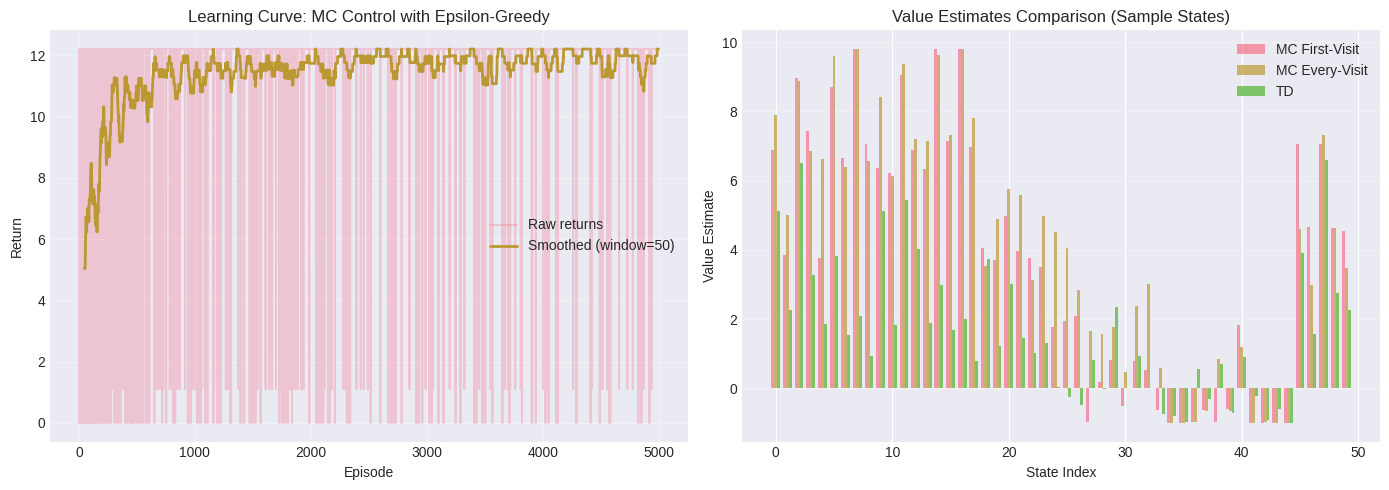

In [ ]:
# Plot learning curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Episode returns
window = 50
smoothed_returns = np.convolve(returns_mc, np.ones(window)/window, mode='valid')

axes[0].plot(returns_mc, alpha=0.3, label='Raw returns')
axes[0].plot(range(window-1, len(returns_mc)), smoothed_returns,
             linewidth=2, label=f'Smoothed (window={window})')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Return')
axes[0].set_title('Learning Curve: MC Control with Epsilon-Greedy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Comparison of value estimates
common_states = set(V_mc_first.keys()) & set(V_mc_every.keys()) & set(V_td.keys())
common_states = list(common_states)[:50]  # Sample for visualization

mc_first_values = [V_mc_first[s] for s in common_states]
mc_every_values = [V_mc_every[s] for s in common_states]
td_values = [V_td[s] for s in common_states]

x = np.arange(len(common_states))
width = 0.25

axes[1].bar(x - width, mc_first_values, width, label='MC First-Visit', alpha=0.7)
axes[1].bar(x, mc_every_values, width, label='MC Every-Visit', alpha=0.7)
axes[1].bar(x + width, td_values, width, label='TD', alpha=0.7)

axes[1].set_xlabel('State Index')
axes[1].set_ylabel('Value Estimate')
axes[1].set_title('Value Estimates Comparison (Sample States)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Convergence Speed Analysis

In [ ]:
print("Convergence Speed Analysis")
print("=" * 70)

# Compare convergence of different methods
methods = [
    ('MC First-Visit', V_mc_first),
    ('MC Every-Visit', V_mc_every),
    ('TD(0)', V_td)
]

print("\nValue Function Statistics:")
print("-" * 70)
for name, V in methods:
    values = list(V.values())
    print(f"\n{name}:")
    print(f"  States evaluated: {len(V)}")
    print(f"  Mean value: {np.mean(values):.4f}")
    print(f"  Std deviation: {np.std(values):.4f}")
    print(f"  Max value: {np.max(values):.4f}")
    print(f"  Min value: {np.min(values):.4f}")

print("\n" + "=" * 70)
print("\nMonte Carlo Control Performance:")
print("-" * 70)
print(f"Total episodes: {len(returns_mc)}")
print(f"Average return (first 100): {np.mean(returns_mc[:100]):.2f}")
print(f"Average return (last 100): {np.mean(returns_mc[-100:]):.2f}")
print(f"Improvement: {np.mean(returns_mc[-100:]) - np.mean(returns_mc[:100]):.2f}")
print(f"\nLearned policy states: {len(Q_mc)}")

Convergence Speed Analysis

Value Function Statistics:
----------------------------------------------------------------------

MC First-Visit:
  States evaluated: 245
  Mean value: 3.9930
  Std deviation: 2.9285
  Max value: 9.8051
  Min value: -1.0000

MC Every-Visit:
  States evaluated: 245
  Mean value: 4.1271
  Std deviation: 2.9335
  Max value: 9.8021
  Min value: -1.0000

TD(0):
  States evaluated: 306
  Mean value: 1.0603
  Std deviation: 1.4794
  Max value: 6.6120
  Min value: -0.9929


Monte Carlo Control Performance:
----------------------------------------------------------------------
Total episodes: 5000
Average return (first 100): 6.29
Average return (last 100): 11.97
Improvement: 5.68

Learned policy states: 245


## Summary and Conclusions

### Task 1: Value Iteration with Gamma = 1
- **Counterexample**: Infinite corridor MDP with constant positive rewards
- **Issue**: Values grow unbounded, no convergence
- **Solution**: Use $\gamma < 1$ or ensure finite episodes

### Task 2: Greedy vs Epsilon-Greedy
- **Greedy**: Exploits current knowledge, can get stuck in local optima
- **Epsilon-Greedy**: Balances exploration and exploitation
- **Result**: Epsilon-greedy discovers better policies through exploration

### Task 3: Implementation Results

#### Monte Carlo Methods:
- **First-Visit**: Unbiased, lower variance than every-visit
- **Every-Visit**: More updates per episode, faster convergence
- **Convergence**: Both converge to true values with enough episodes

#### Temporal Difference:
- **Advantages**: Online learning, lower variance, faster convergence
- **Bootstrapping**: Uses current estimates, biased but efficient
- **Performance**: Often converges faster than MC in practice

#### Value Iteration:
- **Challenge**: Large state space makes exact VI computationally expensive
- **Solution**: Sampling-based approaches or function approximation
- **Convergence**: Guaranteed with $\gamma < 1$

#### Policy Iteration:
- **Efficiency**: Often converges in fewer iterations than VI
- **Cost**: Each iteration requires policy evaluation
- **Optimality**: Guaranteed to find optimal policy

#### MC Control with Epsilon-Greedy:
- **Exploration**: Essential for discovering optimal policy
- **Learning**: Improves over time as shown in learning curve
- **Practical**: Works well for complex environments like Breakout

### Key Insights:

1. **Discount Factor**: Critical for convergence, $\gamma < 1$ ensures bounded values

2. **Exploration**: Necessary for finding optimal policies in unknown environments

3. **Bias-Variance Tradeoff**: MC (high variance, unbiased) vs TD (low variance, biased)

4. **Convergence Speed**: TD often faster than MC, epsilon-greedy enables learning

5. **Scalability**: Large state spaces require approximation methods or sampling

### Recommendations for Atari Breakout:

1. Use $\gamma = 0.99$ for stable learning
2. Implement epsilon-greedy with decaying epsilon
3. Consider TD methods (Q-learning, SARSA) for online learning
4. Use function approximation (neural networks) for large state spaces
5. Combine exploration strategies (epsilon-greedy, UCB, etc.)